In [1]:
# This notebook tests that stationarity of the economic variables
# and then makes stationary any variables that are not stationary.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
# Set data types for features
dts = {"month_date": str, "gdp": np.float64
       , "tb": np.float64, "pi": np.float64
       , "ur": np.float64, "nyse": np.float64
       , "pce": np.float64, "ics": np.float64}

In [5]:
# Set date feature to be parsed
parse_dates = ['month_date']

In [6]:
# Import data
data = pd.read_csv("data/econ_vars_consolidated.txt"
                   , sep="\t"
                   , skiprows=0
                   , dtype=dts
                   , parse_dates=parse_dates)

In [7]:
# Filter data for dates greater than December 31, 1977
data = data[data["month_date"] > "1977-12-31"]

In [8]:
# Create a new featue converting datatime to month
data["month"] = data["month_date"].dt.to_period('M')

In [9]:
# Set the index to the new month feature
data = data.set_index("month")

In [10]:
# Convert some of the features to growth rates from the previous period
data['pi_gr'] = data['pi'].pct_change(periods=1)
data['nyse_gr'] = data['nyse'].pct_change(periods=1)
data['pce_gr'] = data['pce'].pct_change(periods=1)

In [11]:
# Filter the data to use only the last 93 observations Oct 2010 to Jun 2018
data = data.iloc[-93:,:]

<function matplotlib.pyplot.show(*args, **kw)>

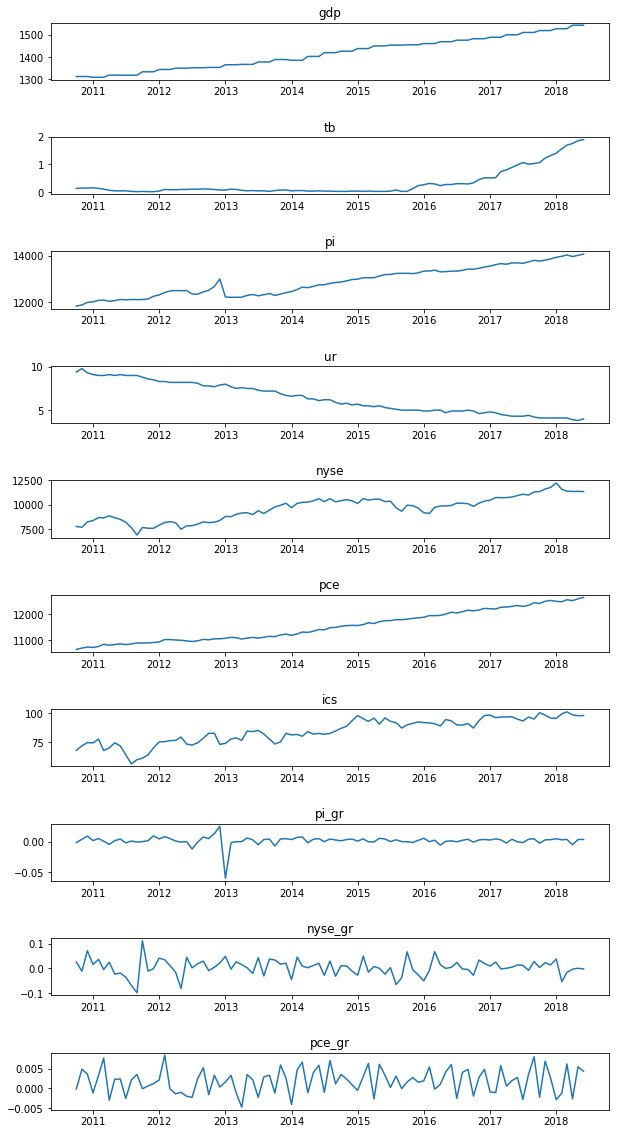

In [12]:
# Plot all the economic features including the feature converted to growth rates to look at possible trends
# Create one figure for plots
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, 1, figsize=(10,20))

# Make a little extra space between the subplots
fig.subplots_adjust(hspace=1)

# Plot each feature on its own axis
ax1.plot(data['month_date'], data['gdp'])
ax1.set_title(data['gdp'].name)

ax2.plot(data['month_date'], data['tb'])
ax2.set_title(data['tb'].name)

ax3.plot(data['month_date'], data['pi'])
ax3.set_title(data['pi'].name)

ax4.plot(data['month_date'], data['ur'])
ax4.set_title(data['ur'].name)

ax5.plot(data['month_date'], data['nyse'])
ax5.set_title(data['nyse'].name)

ax6.plot(data['month_date'], data['pce'])
ax6.set_title(data['pce'].name)

ax7.plot(data['month_date'], data['ics'])
ax7.set_title(data['ics'].name)

ax8.plot(data['month_date'], data['pi_gr'])
ax8.set_title(data['pi_gr'].name)

ax9.plot(data['month_date'], data['nyse_gr'])
ax9.set_title(data['nyse_gr'].name)

ax10.plot(data['month_date'], data['pce_gr'])
ax10.set_title(data['pce_gr'].name)

plt.show

In [13]:
from statsmodels.tsa.stattools import adfuller

# Create function to apply the Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [14]:
from statsmodels.tsa.stattools import kpss

# Create function to apply the KPSS test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
# Run the Dickey-Fuller test on each economic feature
for column in data.iloc[:, 1:8]:
    print ("\nTest Variable: {}\n".format(column))
    adf_test(data[column].dropna())


Test Variable: gdp

Results of Dickey-Fuller Test:
Test Statistic                  0.438833
p-value                         0.982890
#Lags Used                      9.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64

Test Variable: tb

Results of Dickey-Fuller Test:
Test Statistic                  3.221647
p-value                         1.000000
#Lags Used                      5.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64

Test Variable: pi

Results of Dickey-Fuller Test:
Test Statistic                  0.576828
p-value                         0.987030
#Lags Used                      5.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895

In [16]:
# Run the KPSS test on each economic feature

for column in data.iloc[:, 1:8]:
    print ("\nTest Variable: {}\n".format(column))
    kpss_test(data[column].dropna())


Test Variable: gdp

Results of KPSS Test:
Test Statistic            0.828294
p-value                   0.010000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Test Variable: tb

Results of KPSS Test:
Test Statistic            0.553467
p-value                   0.029625
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Test Variable: pi

Results of KPSS Test:
Test Statistic            0.813408
p-value                   0.010000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Test Variable: ur

Results of KPSS Test:
Test Statistic            0.815901
p-value         

In [17]:
# Create a function that displays two plots comparing stationary transformations
# Includes rolling mean

def two_plots(x, x_log):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
    fig.subplots_adjust(hspace=0.25)
    rm1 = x.rolling(window=12).mean()
    rm2 = x_log.rolling(window=12).mean()
    ax1.plot(data['month_date'], x)
    ax1.plot(data['month_date'], rm1)
    ax1.set_title(x.name)
    ax2.plot(data['month_date'], x_log)
    ax2.plot(data['month_date'], rm2)
    ax2.set_title(x_log.name)
    plt.show()

In [18]:
# Create a function that displays three plots comparing transformations
# First two plots are same as above
# Third plot includes rolling mean and rolling standar deviation

def three_plots(x, x_log, x_log_diff):   
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))
    fig.subplots_adjust(hspace=0.5)
    rm1 = x.rolling(window=12).mean()
    rm2 = x_log.rolling(window=12).mean()
    rm3 = x_log_diff.rolling(window=12).mean()
    rsd3 = x_log_diff.rolling(window=12).std()
    ax1.plot(data['month_date'], x)
    ax1.plot(data['month_date'], rm1)
    ax1.set_title(x.name)
    ax2.plot(data['month_date'], x_log)
    ax2.plot(data['month_date'], rm2)
    ax2.set_title(x_log.name)
    ax3.plot(data['month_date'], x_log_diff)
    ax3.plot(data['month_date'], rm3)
    ax3.plot(data['month_date'], rsd3)
    ax3.set_title(x_log_diff.name)
    plt.show()

In [19]:
# Log transform
data['gdp_log'] = np.log(data['gdp'])

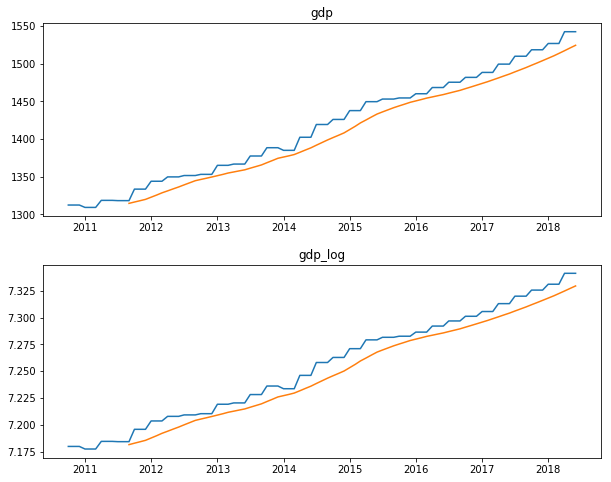

In [20]:
two_plots(data['gdp'], data['gdp_log'])

In [21]:
# Difference the log transform order 2
data['gdp_log_diff'] = data['gdp_log'] - data['gdp_log'].shift(2)

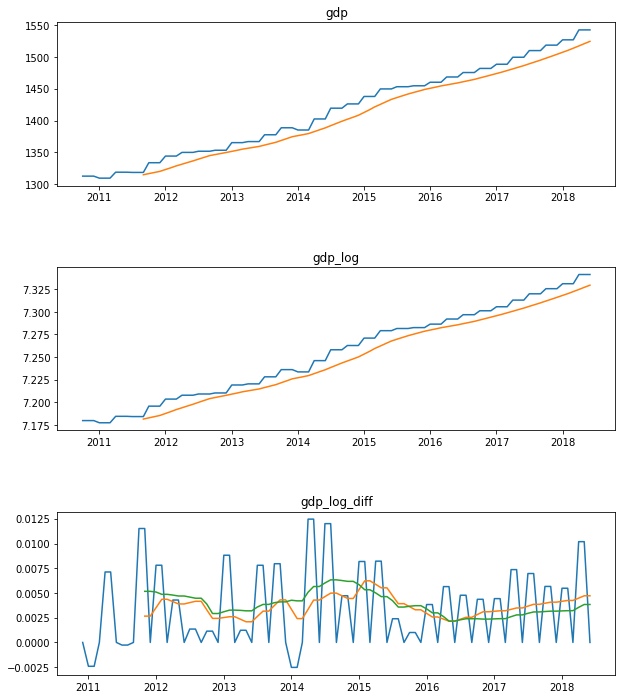

In [22]:
three_plots(data['gdp'], data['gdp_log'], data['gdp_log_diff'])

In [23]:
# Square root transform
data['tb_sqrt'] =np.sqrt(data['tb'])

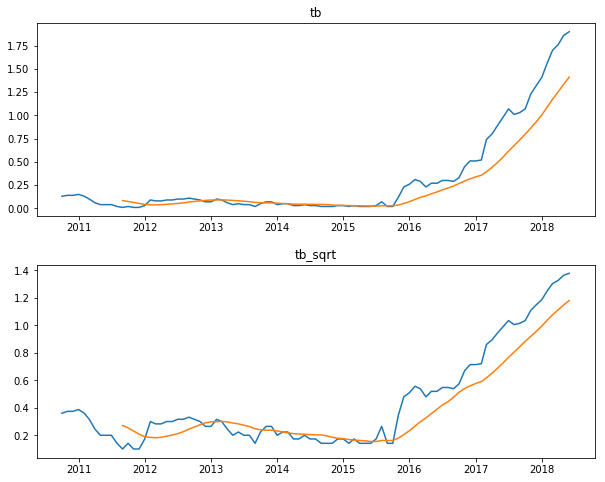

In [24]:
two_plots(data['tb'], data['tb_sqrt'])

In [25]:
# Difference the square root transform 1 order
data['tb_sqrt_diff'] = data['tb_sqrt'] - data['tb_sqrt'].shift(1)

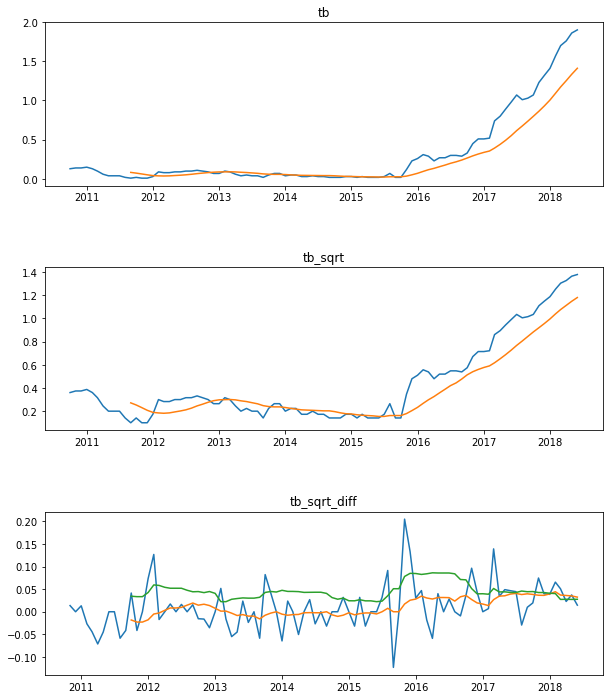

In [26]:
three_plots(data['tb'], data['tb_sqrt'], data['tb_sqrt_diff'])

In [27]:
# Log transform
data['pi_log'] = np.log(data['pi'])

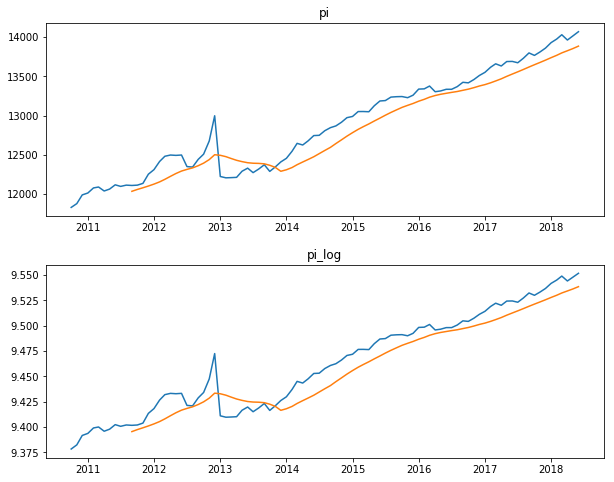

In [28]:
two_plots(data['pi'], data['pi_log'])

In [29]:
# Difference the log transform 1 order
data['pi_log_diff'] = data['pi_log'] - data['pi_log'].shift(1)

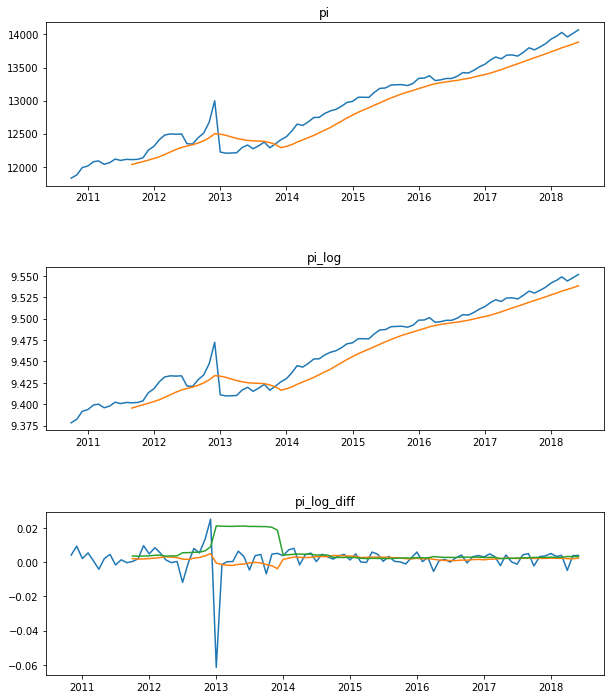

In [30]:
three_plots(data['pi'], data['pi_log'], data['pi_log_diff'])

In [31]:
# Log transform
data['nyse_log'] = np.log(data['nyse'])

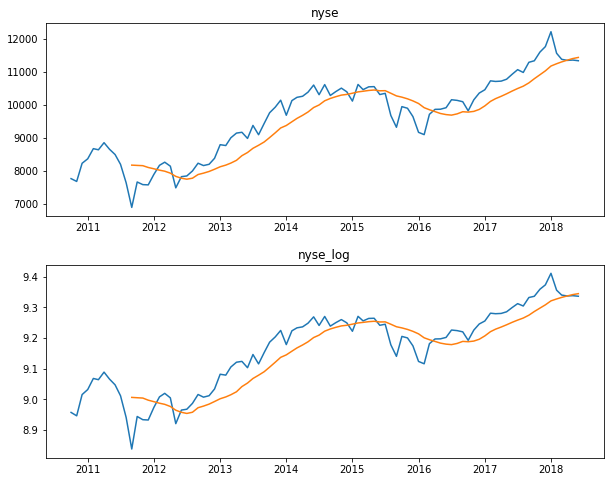

In [32]:
two_plots(data['nyse'], data['nyse_log'])

In [33]:
# Difference the log transform 1 order
data['nyse_log_diff'] = data['nyse_log'] - data['nyse_log'].shift(1)

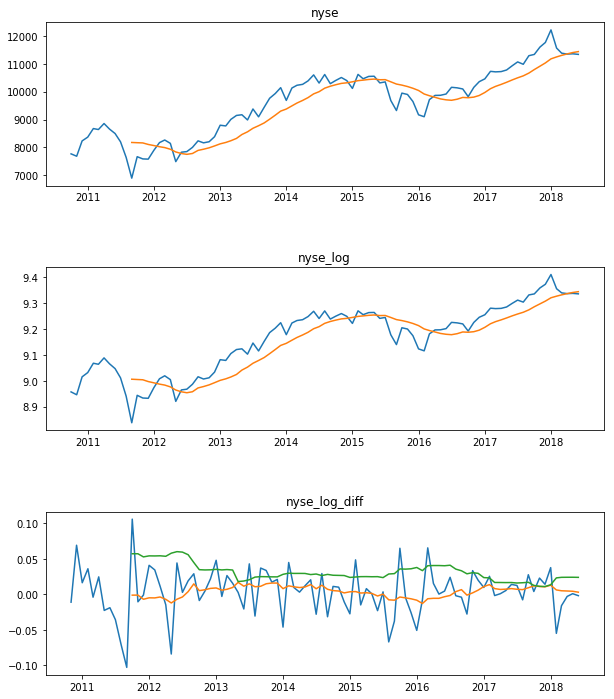

In [34]:
three_plots(data['nyse'], data['nyse_log'], data['nyse_log_diff'])

In [35]:
# Log transform
data['pce_log'] = np.log(data['pce'])

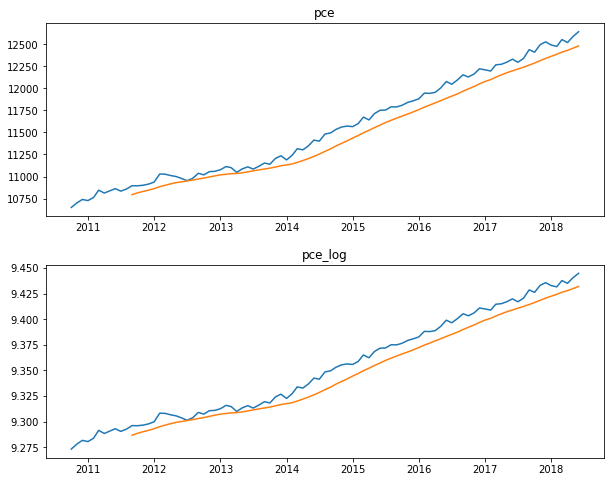

In [36]:
two_plots(data['pce'], data['pce_log'])

In [37]:
# Difference the log transform 1 order
data['pce_log_diff'] = data['pce_log'] - data['pce_log'].shift(1)

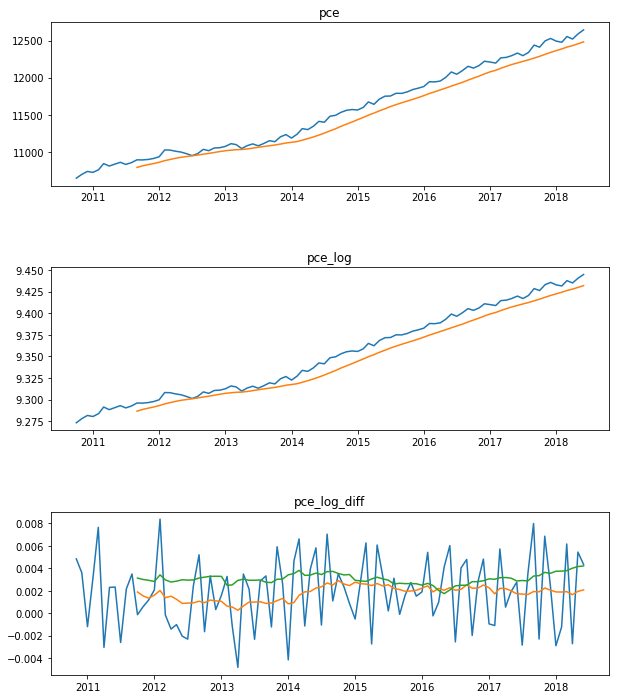

In [38]:
three_plots(data['pce'], data['pce_log'], data['pce_log_diff'])

In [39]:
# Log transform
data['ics_log'] = np.log(data['ics'])

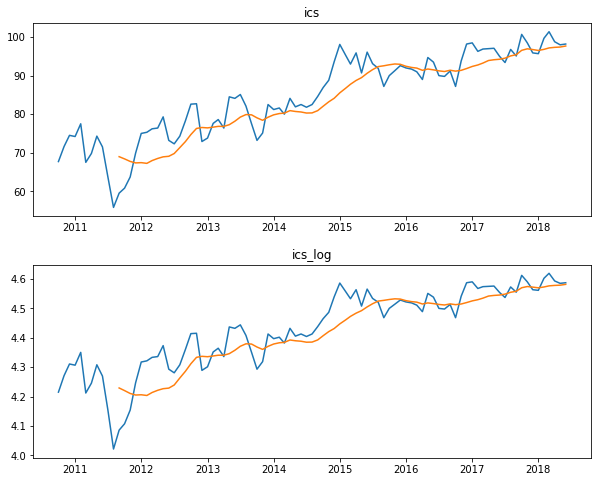

In [40]:
two_plots(data['ics'], data['ics_log'])

In [41]:
# Difference the log transform 1 order
data['ics_log_diff'] = data['ics_log'] - data['ics_log'].shift(1)

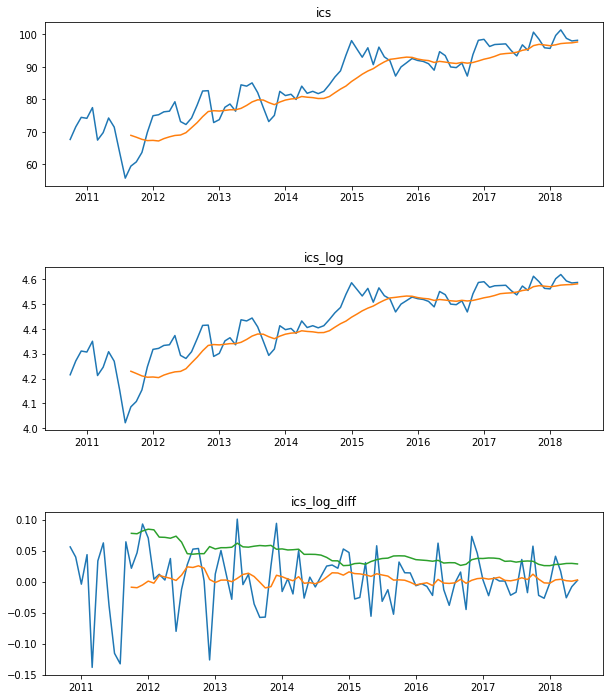

In [42]:
three_plots(data['ics'], data['ics_log'], data['ics_log_diff'])

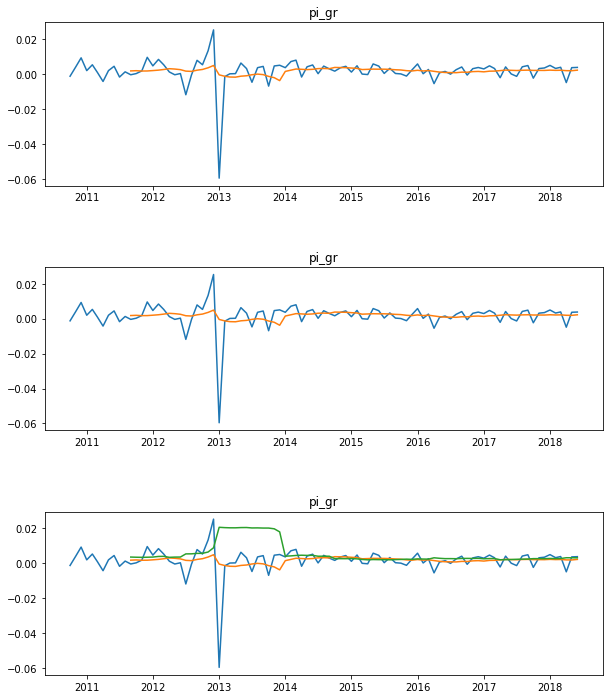

In [43]:
# No transformation
three_plots(data['pi_gr'],data['pi_gr'],data['pi_gr'])

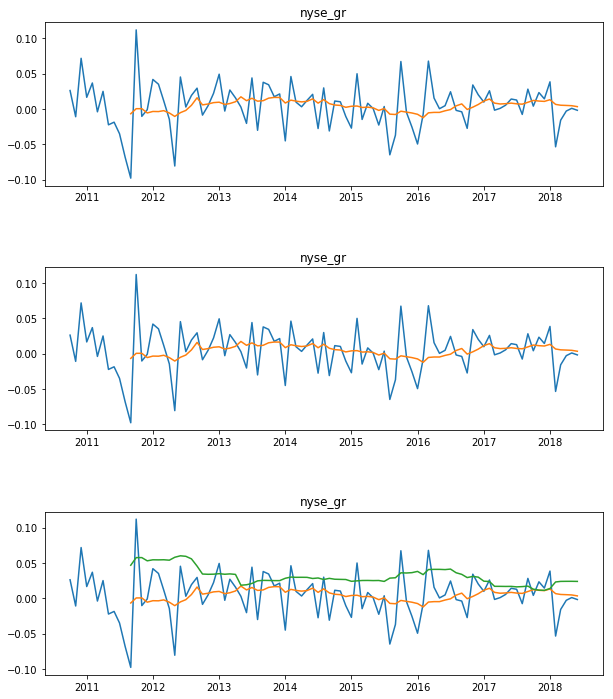

In [44]:
# No transformation
three_plots(data['nyse_gr'],data['nyse_gr'],data['nyse_gr'])

In [45]:
# Difference the growth rate feature 1 order
data['pce_gr_diff'] = data['pce_gr'] - data['pce_gr'].shift(1)

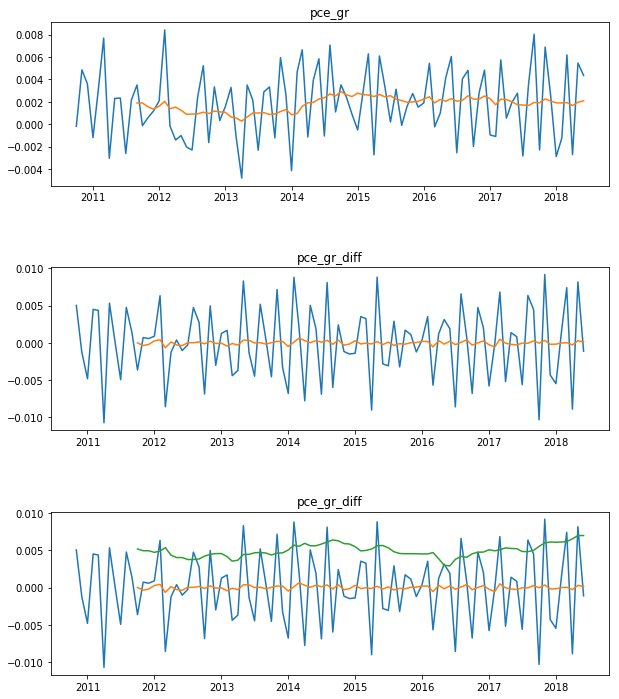

In [46]:
three_plots(data['pce_gr'],data['pce_gr_diff'],data['pce_gr_diff'])

In [47]:
# Set comlumns to test for stationarity after transformations
test_columns = ['gdp_log_diff', 'tb_sqrt_diff'
               , 'nyse_log_diff', 'ics_log_diff'
               ,'pi_gr','nyse_gr','pce_gr_diff']

In [48]:
# Run the Dickey-Fuller test on the stationary features
for column in data[test_columns]:
    print ("\nTest Variable: {}\n".format(column))
    adf_test(data[column].dropna())


Test Variable: gdp_log_diff

Results of Dickey-Fuller Test:
Test Statistic                 -3.523739
p-value                         0.007398
#Lags Used                      9.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64

Test Variable: tb_sqrt_diff

Results of Dickey-Fuller Test:
Test Statistic                -6.682881e+00
p-value                        4.297854e-09
#Lags Used                     1.000000e+00
Number of Observations Used    9.000000e+01
Critical Value (1%)           -3.505190e+00
Critical Value (5%)           -2.894232e+00
Critical Value (10%)          -2.584210e+00
dtype: float64

Test Variable: nyse_log_diff

Results of Dickey-Fuller Test:
Test Statistic                -1.021941e+01
p-value                        5.373769e-18
#Lags Used                     0.000000e+00
Number of Observations Used    9.100000e+01
Critical Value 

In [49]:
# Run the KPSS test on the stationary features

for column in data[test_columns]:
    print ("\nTest Variable: {}\n".format(column))
    kpss_test(data[column].dropna())


Test Variable: gdp_log_diff

Results of KPSS Test:
Test Statistic            0.176418
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Test Variable: tb_sqrt_diff

Results of KPSS Test:
Test Statistic            0.582650
p-value                   0.024214
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Test Variable: nyse_log_diff

Results of KPSS Test:
Test Statistic            0.071732
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Test Variable: ics_log_diff

Results of KPSS Test:
Test Statis

In [50]:
# List all the features in the dataframe
print (data.columns)

Index(['month_date', 'gdp', 'tb', 'pi', 'ur', 'nyse', 'pce', 'ics', 'pi_gr',
       'nyse_gr', 'pce_gr', 'gdp_log', 'gdp_log_diff', 'tb_sqrt',
       'tb_sqrt_diff', 'pi_log', 'pi_log_diff', 'nyse_log', 'nyse_log_diff',
       'pce_log', 'pce_log_diff', 'ics_log', 'ics_log_diff', 'pce_gr_diff'],
      dtype='object')


In [51]:
# Create dataframe with only the stationry features
data_stationary = data.drop(data.columns[[1,2,3,5,6,7,10,11,13,15,16,17,18,19,20,21]], axis=1)

In [52]:
# Confirm the stationary columns are in the new dataframe
print (data_stationary.columns)

Index(['month_date', 'ur', 'pi_gr', 'nyse_gr', 'gdp_log_diff', 'tb_sqrt_diff',
       'ics_log_diff', 'pce_gr_diff'],
      dtype='object')


In [53]:
# Drop observations that have Nan from differencing
data_stationary = data_stationary.dropna()

In [54]:
# Confirm shape of the stationary dataframe
data_stationary.shape

(91, 8)

In [55]:
# Output to CSV
data_stationary.to_csv("data/econ_vars.csv", sep=",", index=False)